# Applying formal verification to ensure a language model always outputs balanced parentheses

We will train a scaled-down version of GPT-2 to complete sequences of parentheses so that the result is balanced. Then we will use the auto_LiRPA verification library to check that for any input sequence can be balanced, the output will in fact be balanced.


In [ ]:
!pip install git+https://github.com/AlejoAcelas/auto_LiRPA.git
import numpy as np
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm
# Importing Verification Library

# 1. Training set

We'll start by generating all balanced sequences of 20 parentheses. We will use a 3-token vocabulary, composed of the tokens '(', ')', and '_'. '_' will be used as a padding and end-of-sentence token.

In [ ]:
def is_balanced(seq):
  seq = seq.replace('_','')
  s = 0
  for x in seq:
    s += 1 if x == '(' else -1
    if s < 0:
      return False
  return s == 0

def decode(seq):
    return ''.join(['_()'[int(x)] for x in seq])

def encode(seqs):
    maxlen = max([len(s) for s in seqs])
    out = []
    att_mask = []
    for s in seqs:
        enc = [{'(': 1, ')': 2, '_': 0}[x] for x in s]
        att_mask.append([0]*(maxlen-len(enc))+[1]*len(enc))
        enc = [0]*(maxlen-len(enc)) + enc
        out.append(enc)
    return torch.tensor(out, dtype=torch.long), torch.tensor(att_mask, dtype=torch.long)

def generate_positive_examples(max_length):
    init = [1]
    def next_token(current, results, max_length):
        if len(current) == max_length:
            if sum(current) == 0:
                results.append(current+[0])
            return
        if sum(current) == max_length-len(current):
            results.append(current+[-1]*(max_length-len(current)) + [0])
            return
        elif sum(current) == 0:
            results.append(current + [0])
            next_token(current+[1], results, max_length)
        elif sum(current) > 0:
            next_token(current+[1], results, max_length)
            next_token(current+[-1], results, max_length)
    results = []
    next_token(init, results, max_length)
    return list(map(decode,results))

MAX_LENGTH=22
positive_examples = generate_positive_examples(MAX_LENGTH)
print(positive_examples[:10])
print(len(positive_examples))

['((((((((((()))))))))))_', '(((((((((()())))))))))_', '(((((((((())()))))))))_', '(((((((((()))())))))))_', '(((((((((())))()))))))_', '(((((((((()))))())))))_', '(((((((((())))))()))))_', '(((((((((()))))))())))_', '(((((((((())))))))()))_', '(((((((((()))))))))())_']
82499


# Model

We use the GPT2 architecture as implemented in https://github.com/graykode/gpt-2-Pytorch/blob/master/GPT2/model.py, with minor modifications.

In [ ]:
import copy
import torch
import math
import torch.nn as nn
from torch.nn.parameter import Parameter


class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = Parameter(w)
        self.bias = Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x

class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)

    def _attn(self, q, k, v, attention_mask):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        b = self.bias[:, :, ns-nd:ns, :ns]
        w = w * b - 1e10 * (1 - b)
        w = w + attention_mask
        w = nn.Softmax(dim=-1)(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, attention_mask=None, layer_past=None):
        if attention_mask==None:
          attention_mask = torch.ones_like(x)

        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        a = self._attn(query, key, value, attention_mask)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        return a, present

class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = torch.relu

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        #self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        #self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, attention_mask, layer_past=None):
        if attention_mask == None:
          attention_mask = torch.ones_like(x)

        #a, present = self.attn(self.ln_1(x), layer_past=layer_past)
        a, present = self.attn(x, attention_mask, layer_past=layer_past)
        x = x + a
        #m = self.mlp(self.ln_2(x))
        m = self.mlp(x)
        x = x + m
        return x, present

class GPT2Model(nn.Module):
    def __init__(self, config):
        super(GPT2Model, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.vocab_size

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        #self.ln_f = LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, input_ids, attention_mask, position_ids=None, token_type_ids=None, past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_ids.size(-1) + past_length, dtype=torch.long,
                                        device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        attention_mask = attention_mask.view(attention_mask.shape[0], -1)
        attention_mask = attention_mask[:, None, None, :]
        attention_mask = (1.0 - attention_mask) * -1e30

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_ids.size(-1))
        position_ids = position_ids.view(-1, position_ids.size(-1))

        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        presents = []
        for block, layer_past in zip(self.h, past):
            hidden_states, present = block(hidden_states, attention_mask, layer_past)
            presents.append(present)
        #hidden_states = self.ln_f(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)
        return hidden_states.view(*output_shape), presents

class GPT2LMHead(nn.Module):
    def __init__(self, model_embeddings_weights, config):
        super(GPT2LMHead, self).__init__()
        self.n_embd = config.n_embd
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        # Truncated Language modeling logits (we remove the last token)
        # h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(hidden_state)
        return lm_logits

class GPT2LMHeadModel(nn.Module):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__()
        self.transformer = GPT2Model(config)
        self.lm_head = GPT2LMHead(self.transformer.wte.weight, config)

    def set_tied(self):
        """ Make sure we are sharing the embeddings
        """
        self.lm_head.set_embeddings_weights(self.transformer.wte.weight)

    def forward(self, input_ids, attention_mask, lm_labels=None, position_ids=None, token_type_ids=None, past=None):
        hidden_states, presents = self.transformer(input_ids, attention_mask, position_ids, token_type_ids, past)
        lm_logits = self.lm_head(hidden_states)
        if lm_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(lm_logits[:,:-1,:].reshape(-1, lm_logits.size(-1)), lm_labels[:,1:].reshape(-1))
            return loss
        return lm_logits


Our model has 3 layers, 4 attention heads and width 32

In [ ]:
from collections import namedtuple

Config = namedtuple('Config', [
    'vocab_size',
    'n_positions',
    'n_ctx',
    'n_embd',
    'n_layer',
    'n_head',
])

model = GPT2LMHeadModel(Config(vocab_size=3, n_positions=32, n_ctx=1024, n_embd=32, n_layer=3, n_head=4))

# Training

First we test the model on the test set (1000 sequences selected randomly) to see the untrained prediction performance.

In [ ]:
from random import randint, seed 

seed(0)
n_test = 1000
test_set = [positive_examples.pop(randint(0,len(positive_examples))) for i in range(n_test)]
inp, att_mask = encode(test_set)
loss = float(model(inp, att_mask, lm_labels=inp).detach())
print(loss)

19.50577163696289


Then we train it on the training set (the rest of the sequences) for a single epoch.

In [ ]:
optim = torch.optim.AdamW(model.parameters())

data  = len(positive_examples)
bs = 32
epochs = 1
for e in range(epochs):
  print('Epoch ',e)
  for b in range(data//bs):
      if b % 10 == 0:
          print(b*bs)
      inp, att_mask = encode(positive_examples[b*bs:(b+1)*bs])
      loss = model(inp, att_mask, lm_labels=inp)
      optim.zero_grad()
      loss.backward()
      optim.step()

Epoch  0
0
320
640
960
1280
1600
1920
2240
2560
2880
3200
3520
3840
4160
4480
4800
5120
5440
5760
6080
6400
6720
7040
7360
7680
8000
8320
8640
8960
9280
9600
9920
10240
10560
10880
11200
11520
11840
12160
12480
12800
13120
13440
13760
14080
14400
14720
15040
15360
15680
16000
16320
16640
16960
17280
17600
17920
18240
18560
18880
19200
19520
19840
20160
20480
20800
21120
21440
21760
22080
22400
22720
23040
23360
23680
24000
24320
24640
24960
25280
25600
25920
26240
26560
26880
27200
27520
27840
28160
28480
28800
29120
29440
29760
30080
30400
30720
31040
31360
31680
32000
32320
32640
32960
33280
33600
33920
34240
34560
34880
35200
35520
35840
36160
36480
36800
37120
37440
37760
38080
38400
38720
39040
39360
39680
40000
40320
40640
40960
41280
41600
41920
42240
42560
42880
43200
43520
43840
44160
44480
44800
45120
45440
45760
46080
46400
46720
47040
47360
47680
48000
48320
48640
48960
49280
49600
49920
50240
50560
50880
51200
51520
51840
52160
52480
52800
53120
53440
53760
54080
54400
547

Now we test the prediction loss again to check that the model has learned something.

In [ ]:
inp_test, att_mask = encode(test_set)
loss_test = float(model(inp_test, att_mask, lm_labels=inp_test).detach())
print("Loss in test dataset: ", loss_test)

Loss in test dataset:  1.6770515441894531


# Testing

We prompt the model with the initial portion of a balanced sequence and check how often it outputs a balanced completion. This should take less than a minute.

1
2
3
4
5
6
7
8
9
10
11
12


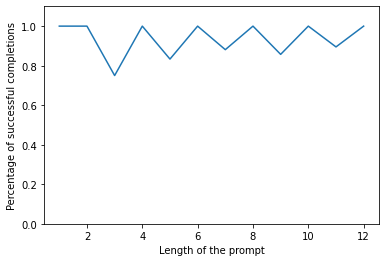

In [ ]:
res = []
for lim in range(1,13):
    print(f'{lim}/13')
    prompts = list({x[:lim] for x in positive_examples})
    inp, att_mask = encode(prompts)
    results = []
    for idx in range(inp.shape[0]):
        lim = 10
        ex = inp[idx].reshape(1,-1)
        atm = att_mask[idx].reshape(1,-1)
        for i in range(MAX_LENGTH):
            logits = model(ex, atm)[0]
            next_tok = logits.argmax(1)[-1].detach().reshape(1,1)
            ex = torch.concat([ex, next_tok],dim=1)
            atm = torch.concat([atm, torch.ones(1,1)], dim=1)
            if int(next_tok[0,0].cpu()) == 0:
                break
        out = decode(ex[0])
        results.append(is_balanced(out))
    res.append(sum(results)/len(results))

from matplotlib import pyplot as plt

plt.plot(list(range(1,13)), res)
plt.xlabel('Length of the prompt')
plt.ylabel('Percentage of successful completions')
plt.ylim(0,1.1)
plt.show()

The model is not perfect, but it achieves a reasonable accuracy. With a larger model, and more iterations, it's plausible that we could reach 100% accuracy on our dataset.

However, we would still not know if the model also behaves as expected on longer sequences outside our dataset. To ensure this we need verification.

# Verification

To verify our model, we'll define a perturbation set on the input space and find bounds for the output within this set. The set is defined by the following linear bounds, where x_i is the encoding of the ith token.

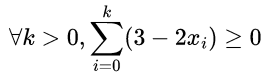

We define a the optimization problem to be solved to find the bound within this set and wrap it in a Perturbation class for use with the auto_LiRPA library.

In [ ]:
from auto_LiRPA.operators.softmax import PerturbationL0Norm
from scipy.optimize import linprog

class PerturbationParenthesis():
    def __init__(self, x, eps=1):
        self.eps = set_eps
        self.x = x

    def concretize_helper(self, x, A, sign=-1, aux=None):
        if type(A) != np.ndarray:
            A = A.to_numpy()
        n = x.shape[1]
        constrain_mat = (-2)*np.ones(n*n).reshape((n,n))
        constrain_mat = np.tril(constrain_mat)
        constrain_b = 3*(np.arange(n) + 1)
        x_i_bound = (0,2)
        bound = linprog(sign*A, -constrain_mat[1:,:], constrain_b[1:], bounds=n*[x_i_bound])
        return bound.fun


    def concretize(self, x, A, sign=-1, aux=None):
        bound = []
        for i in range(A.shape[0]):
            bound.append(concretize_helper(x, A[i, :], sign=sign))
        return torch.FloatTensor(bound)

    # I took this from the L0-norm perturbation
    def init(self, x, aux=None, forward=False):
        # For other norms, we pass in the BoundedTensor objects directly.
        x_L = x
        x_U = x
        if not forward:
            return LinearBound(None, None, None, None, x_L, x_U), x, None
        else:
            raise NotImplementedError()


NameError: ignored

Unfortunately, at this point the verification library fails. This is because some operations in our model are not well supported, which is understandable since even our simplified version of GPT2 is still quite complex.

In [ ]:
# Wrap the model with auto_LiRPA.
Bmodel = BoundedModule(model, (torch.zeros(1,32).long(), torch.zeros(1,32).long()))

# Define perturbation. Here we add Linf perturbation to input data.
ptb = PerturbationLpNorm(norm=np.inf, eps=1.1)

# Make the input a BoundedTensor with the pre-defined perturbation.
input = BoundedTensor(inp_test[0], ptb)
atm = att_mask[0]

# Compute LiRPA bounds using the backward mode bound propagation (CROWN).
lb, ub = Bmodel.compute_bounds(x=(input, atm), method="backward")

<ipython-input-3-ca8523089509>:53: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
<ipython-input-3-ca8523089509>:39: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  w = w / math.sqrt(v.size(-1))
/usr/local/lib/python3.8/dist-packages/auto_LiRPA/bound_general.py:970: UserWarning: Creating an identity matrix with size 1024x1024 for node BoundTranspose(name="/key.3"). This may indi

RuntimeError: ignored